# Natural Language Processing with Disaster Tweets
# Kaggle Competition - Binary Text Classification

## Table of Contents
1. [Problem Description and Data Overview](#problem-description)
2. [Data Setup and Import Libraries](#setup)
3. [Exploratory Data Analysis (EDA)](#eda)
4. [Text Preprocessing and Feature Engineering](#preprocessing)
5. [Word Embeddings and Text Vectorization](#embeddings)
6. [Model Architecture and Implementation](#model-architecture)
7. [Training and Hyperparameter Tuning](#training)
8. [Results and Analysis](#results)
9. [Conclusion](#conclusion)

---

## 1. Problem Description and Data Overview {#problem-description}

### Problem Statement
This project addresses the Kaggle competition "Natural Language Processing with Disaster Tweets" which involves building a machine learning model to predict whether a given tweet is about a real disaster or not. This is a binary text classification problem with significant real-world applications in emergency response and social media monitoring.

### Business Context and Importance
Twitter has become an important communication channel during emergencies, with people sharing real-time information about disasters. Automated systems that can quickly identify disaster-related tweets can help emergency services respond faster and more effectively. The ability to distinguish between actual disaster reports and metaphorical or non-urgent uses of disaster-related language is crucial for effective emergency response.

### Dataset Description
- **Task**: Binary classification (Disaster: 1, Not Disaster: 0)
- **Training Set**: ~7,613 hand-labeled tweets
- **Test Set**: ~3,263 tweets (unlabeled)
- **Features Available**:
  - `id`: Unique identifier for each tweet
  - `text`: The actual tweet text
  - `location`: Location information (may be blank)
  - `keyword`: Disaster-related keyword (may be blank)
  - `target`: Binary label (1 = disaster, 0 = not disaster) - only in training data

### NLP Challenge Overview
Natural Language Processing (NLP) is a branch of artificial intelligence that helps computers understand, interpret, and manipulate human language. This competition presents classic NLP challenges including:
- **Ambiguity**: Words can have multiple meanings (e.g., "fire" as destruction vs. enthusiasm)
- **Context dependency**: Meaning changes based on surrounding words
- **Informal language**: Tweets contain slang, abbreviations, and non-standard grammar
- **Metaphorical usage**: Disaster words used figuratively
- **Limited character count**: Tweets are constrained to 280 characters


## 2. Data Setup and Import Libraries {#setup}


In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')

# Text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud

# Machine learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, LSTM, GRU, Bidirectional, Dropout, 
                                   Embedding, GlobalMaxPooling1D, Conv1D, 
                                   MaxPooling1D, Flatten, Input, Concatenate)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

# Visualization libraries
from collections import Counter
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Progress tracking
from tqdm import tqdm
tqdm.pandas()

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Download NLTK data
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
except Exception as e:
    print(f"NLTK download error: {e}")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

2025-09-21 00:14:48.474444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758413688.646953      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758413688.696476      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Data paths (adjust based on your environment)
TRAIN_PATH = '/kaggle/input/nlp-getting-started/train.csv'
TEST_PATH = '/kaggle/input/nlp-getting-started/test.csv'
SAMPLE_SUBMISSION_PATH = '/kaggle/input/nlp-getting-started/sample_submission.csv'

# Load the datasets
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
sample_submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)

print("Dataset loaded successfully!")
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

# Display basic information
print(f"\nTraining data columns: {train_df.columns.tolist()}")
print(f"Test data columns: {test_df.columns.tolist()}")

# First few rows
print("\nFirst 5 training samples:")
print(train_df.head())


Dataset loaded successfully!
Training data shape: (7613, 5)
Test data shape: (3263, 4)
Sample submission shape: (3263, 2)

Training data columns: ['id', 'keyword', 'location', 'text', 'target']
Test data columns: ['id', 'keyword', 'location', 'text']

First 5 training samples:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


## 3. Exploratory Data Analysis (EDA) {#eda}

### 3.1 Basic Data Exploration

In [3]:
# Basic statistics
print("=== DATASET OVERVIEW ===")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Features in training: {train_df.columns.tolist()}")

# Check for missing values
print(f"\n=== MISSING VALUES ===")
print("Training set:")
print(train_df.isnull().sum())
print("\nTest set:")
print(test_df.isnull().sum())

# Target distribution
target_counts = train_df['target'].value_counts()
print(f"\n=== TARGET DISTRIBUTION ===")
print(f"Not Disaster (0): {target_counts[0]} ({target_counts[0]/len(train_df)*100:.2f}%)")
print(f"Disaster (1): {target_counts[1]} ({target_counts[1]/len(train_df)*100:.2f}%)")

# Text length analysis
train_df['text_length'] = train_df['text'].str.len()
test_df['text_length'] = test_df['text'].str.len()

print(f"\n=== TEXT LENGTH STATISTICS ===")
print(f"Training set text length stats:")
print(train_df['text_length'].describe())
print(f"\nTest set text length stats:")
print(test_df['text_length'].describe())

=== DATASET OVERVIEW ===
Training samples: 7613
Test samples: 3263
Features in training: ['id', 'keyword', 'location', 'text', 'target']

=== MISSING VALUES ===
Training set:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Test set:
id             0
keyword       26
location    1105
text           0
dtype: int64

=== TARGET DISTRIBUTION ===
Not Disaster (0): 4342 (57.03%)
Disaster (1): 3271 (42.97%)

=== TEXT LENGTH STATISTICS ===
Training set text length stats:
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_length, dtype: float64

Test set text length stats:
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: text_length, dtype: float64


### 3.2 Data Visualization

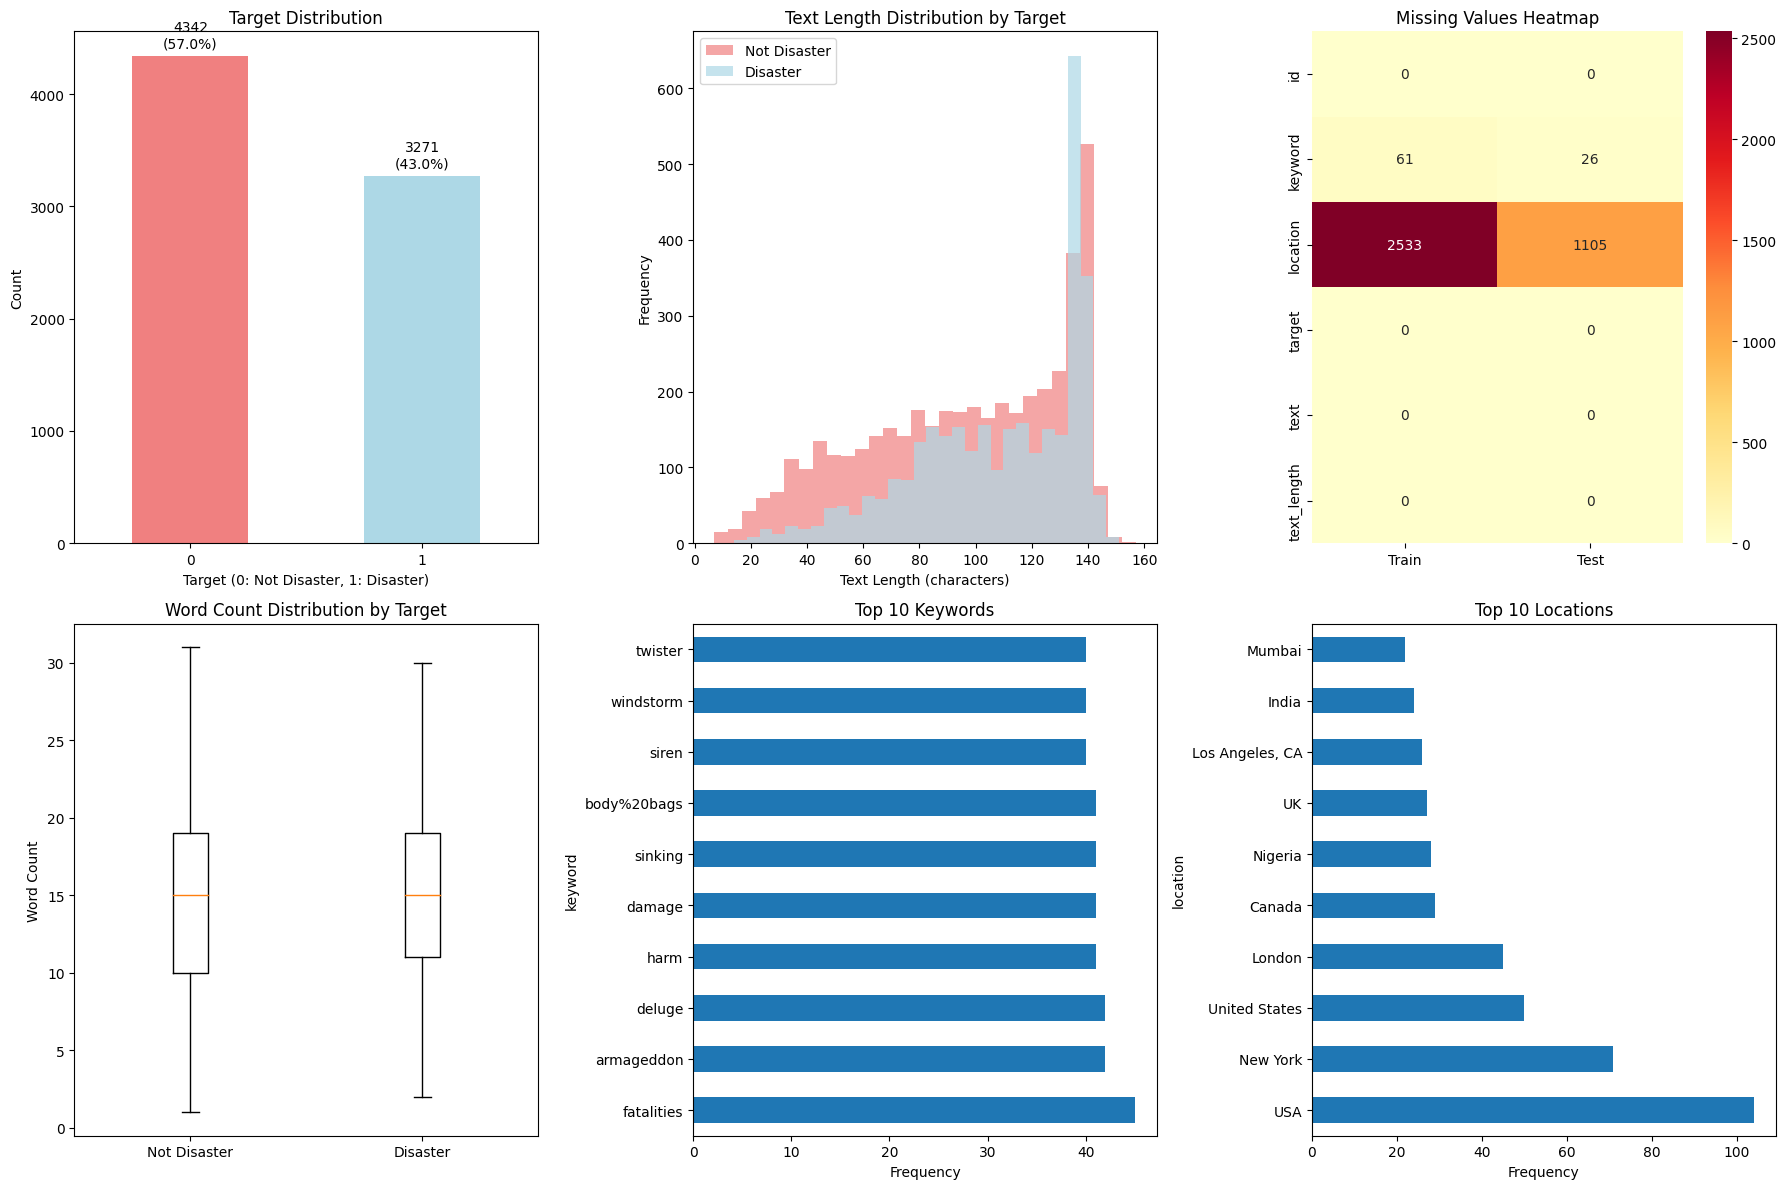


=== ADDITIONAL STATISTICS ===
Average text length (disaster): 108.1
Average text length (not disaster): 95.7
Average word count (disaster): 15.2
Average word count (not disaster): 14.7
Unique keywords: 221
Unique locations: 3341


In [4]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Target distribution
target_counts.plot(kind='bar', ax=axes[0, 0], color=['lightcoral', 'lightblue'])
axes[0, 0].set_title('Target Distribution')
axes[0, 0].set_xlabel('Target (0: Not Disaster, 1: Disaster)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=0)

# Add percentages on bars
for i, v in enumerate(target_counts.values):
    axes[0, 0].text(i, v + 50, f'{v}\n({v/len(train_df)*100:.1f}%)', 
                   ha='center', va='bottom')

# 2. Text length distribution by target
axes[0, 1].hist(train_df[train_df['target']==0]['text_length'], 
               bins=30, alpha=0.7, label='Not Disaster', color='lightcoral')
axes[0, 1].hist(train_df[train_df['target']==1]['text_length'], 
               bins=30, alpha=0.7, label='Disaster', color='lightblue')
axes[0, 1].set_title('Text Length Distribution by Target')
axes[0, 1].set_xlabel('Text Length (characters)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# 3. Missing values heatmap
missing_data = pd.DataFrame({
    'Train': train_df.isnull().sum(),
    'Test': test_df.isnull().sum()
})
# Fill any NaN values with 0 and convert to integers
missing_data = missing_data.fillna(0).astype(int)
sns.heatmap(missing_data, annot=True, fmt='d', cmap='YlOrRd', ax=axes[0, 2])
axes[0, 2].set_title('Missing Values Heatmap')

# 4. Word count analysis
train_df['word_count'] = train_df['text'].str.split().str.len()
test_df['word_count'] = test_df['text'].str.split().str.len()

axes[1, 0].boxplot([train_df[train_df['target']==0]['word_count'].dropna(),
                   train_df[train_df['target']==1]['word_count'].dropna()],
                  labels=['Not Disaster', 'Disaster'])
axes[1, 0].set_title('Word Count Distribution by Target')
axes[1, 0].set_ylabel('Word Count')

# 5. Keyword analysis (top keywords)
keyword_counts = train_df['keyword'].value_counts().head(10)
keyword_counts.plot(kind='barh', ax=axes[1, 1])
axes[1, 1].set_title('Top 10 Keywords')
axes[1, 1].set_xlabel('Frequency')

# 6. Location analysis (top locations)
location_counts = train_df['location'].value_counts().head(10)
location_counts.plot(kind='barh', ax=axes[1, 2])
axes[1, 2].set_title('Top 10 Locations')
axes[1, 2].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n=== ADDITIONAL STATISTICS ===")
print(f"Average text length (disaster): {train_df[train_df['target']==1]['text_length'].mean():.1f}")
print(f"Average text length (not disaster): {train_df[train_df['target']==0]['text_length'].mean():.1f}")
print(f"Average word count (disaster): {train_df[train_df['target']==1]['word_count'].mean():.1f}")
print(f"Average word count (not disaster): {train_df[train_df['target']==0]['word_count'].mean():.1f}")
print(f"Unique keywords: {train_df['keyword'].nunique()}")
print(f"Unique locations: {train_df['location'].nunique()}")

## 3.3 Text Analysis and Visualization


=== TEXT LENGTH STATISTICS ===
Training set:
  Mean length: 101.0 characters
  Median length: 107.0 characters
  Max length: 157 characters

By target class:
  Not Disaster: 95.7 chars, 14.7 words
  Disaster: 108.1 chars, 15.2 words


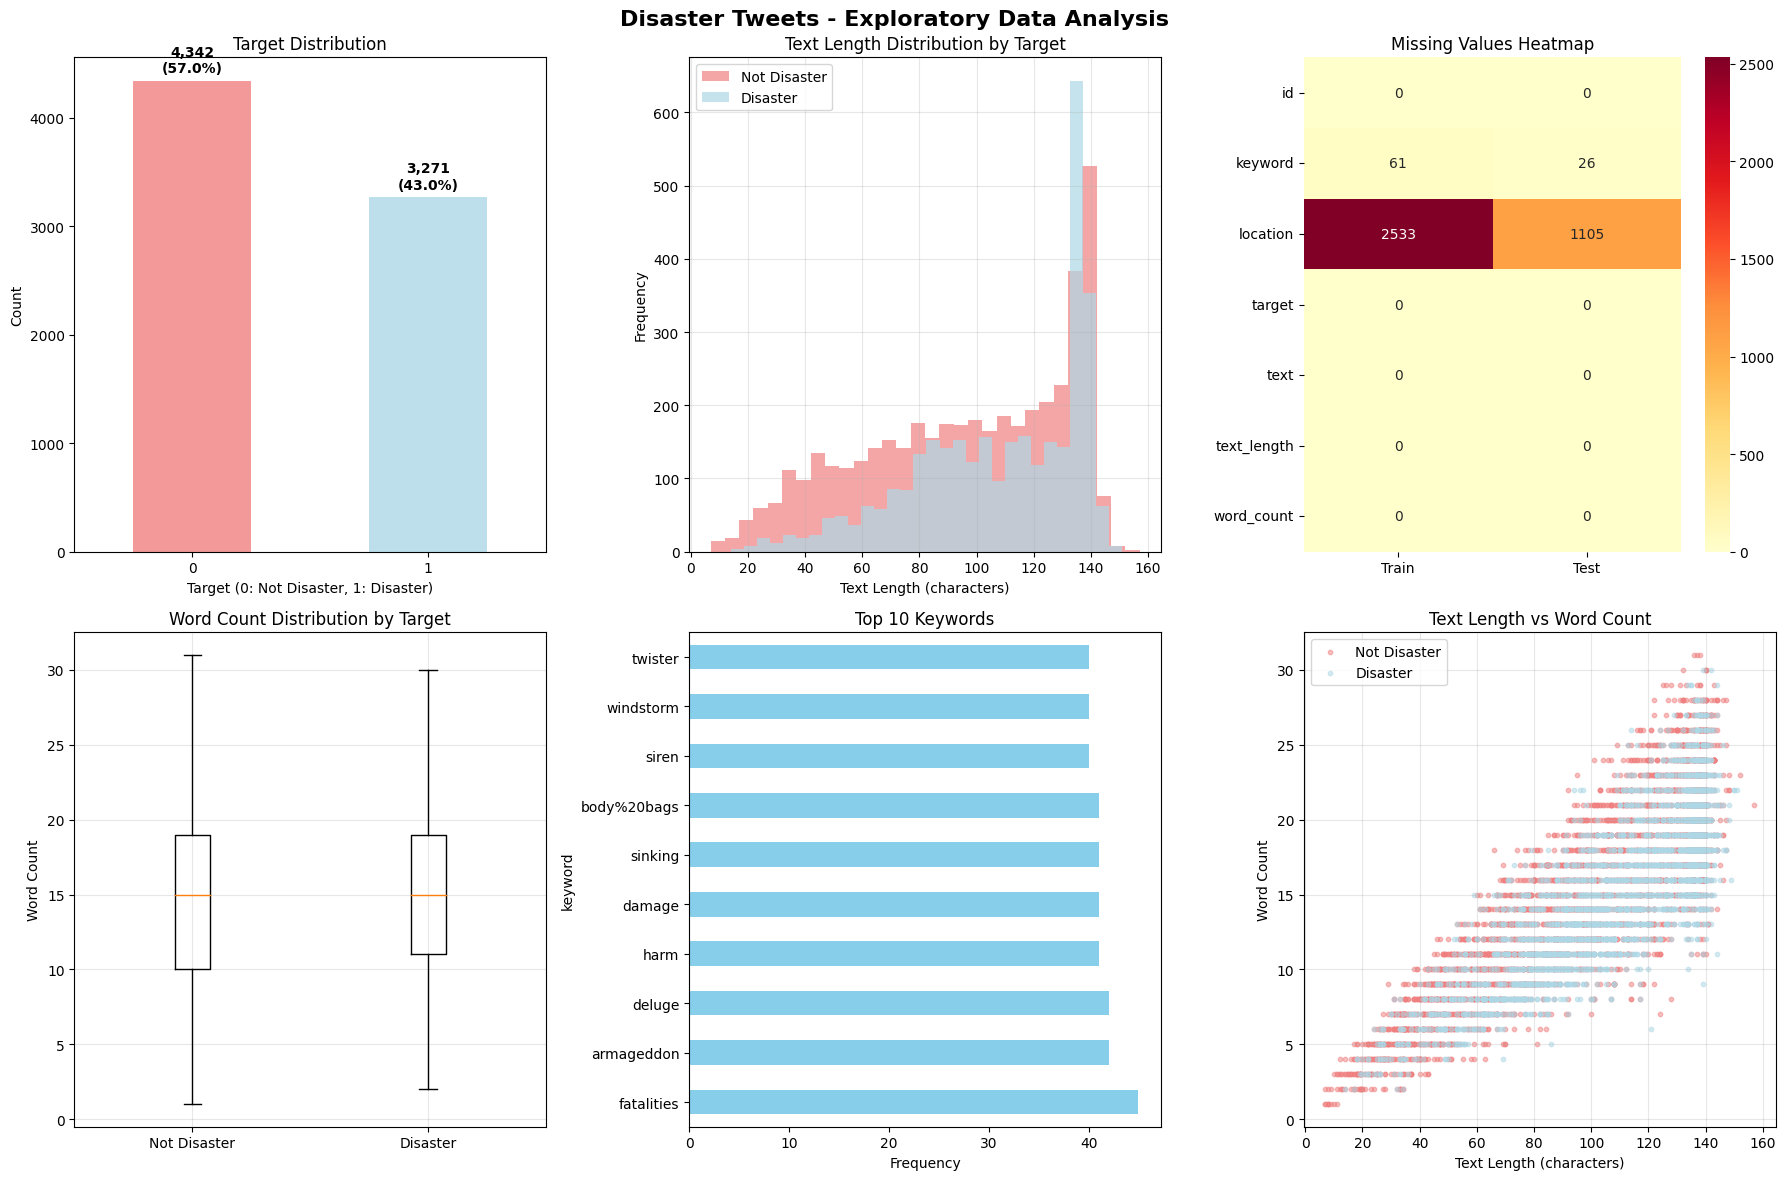

In [5]:

# Text length analysis
train_df['text_length'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()
test_df['text_length'] = test_df['text'].str.len()
test_df['word_count'] = test_df['text'].str.split().str.len()

print(f"\n=== TEXT LENGTH STATISTICS ===")
print("Training set:")
print(f"  Mean length: {train_df['text_length'].mean():.1f} characters")
print(f"  Median length: {train_df['text_length'].median():.1f} characters")
print(f"  Max length: {train_df['text_length'].max()} characters")

print("\nBy target class:")
for target in [0, 1]:
    subset = train_df[train_df['target'] == target]
    label = "Not Disaster" if target == 0 else "Disaster"
    print(f"  {label}: {subset['text_length'].mean():.1f} chars, {subset['word_count'].mean():.1f} words")

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Disaster Tweets - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Target distribution
target_counts.plot(kind='bar', ax=axes[0, 0], color=['lightcoral', 'lightblue'], alpha=0.8)
axes[0, 0].set_title('Target Distribution')
axes[0, 0].set_xlabel('Target (0: Not Disaster, 1: Disaster)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=0)

# Add percentages on bars
for i, v in enumerate(target_counts.values):
    axes[0, 0].text(i, v + 50, f'{v:,}\n({v/len(train_df)*100:.1f}%)', 
                   ha='center', va='bottom', fontweight='bold')

# 2. Text length distribution by target
axes[0, 1].hist(train_df[train_df['target']==0]['text_length'], 
               bins=30, alpha=0.7, label='Not Disaster', color='lightcoral')
axes[0, 1].hist(train_df[train_df['target']==1]['text_length'], 
               bins=30, alpha=0.7, label='Disaster', color='lightblue')
axes[0, 1].set_title('Text Length Distribution by Target')
axes[0, 1].set_xlabel('Text Length (characters)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Missing values heatmap
missing_data = pd.DataFrame({
    'Train': train_df.isnull().sum(),
    'Test': test_df.isnull().sum()
}).fillna(0).astype(int)

sns.heatmap(missing_data, annot=True, fmt='d', cmap='YlOrRd', ax=axes[0, 2], cbar=True)
axes[0, 2].set_title('Missing Values Heatmap')

# 4. Word count distribution
box_data = [train_df[train_df['target']==0]['word_count'].dropna(),
           train_df[train_df['target']==1]['word_count'].dropna()]
axes[1, 0].boxplot(box_data, labels=['Not Disaster', 'Disaster'])
axes[1, 0].set_title('Word Count Distribution by Target')
axes[1, 0].set_ylabel('Word Count')
axes[1, 0].grid(True, alpha=0.3)

# 5. Top keywords analysis
if 'keyword' in train_df.columns:
    keyword_counts = train_df['keyword'].value_counts().head(10)
    keyword_counts.plot(kind='barh', ax=axes[1, 1], color='skyblue')
    axes[1, 1].set_title('Top 10 Keywords')
    axes[1, 1].set_xlabel('Frequency')

# 6. Text length vs target
axes[1, 2].scatter(train_df[train_df['target']==0]['text_length'], 
                  train_df[train_df['target']==0]['word_count'], 
                  alpha=0.5, label='Not Disaster', s=10, color='lightcoral')
axes[1, 2].scatter(train_df[train_df['target']==1]['text_length'], 
                  train_df[train_df['target']==1]['word_count'], 
                  alpha=0.5, label='Disaster', s=10, color='lightblue')
axes[1, 2].set_title('Text Length vs Word Count')
axes[1, 2].set_xlabel('Text Length (characters)')
axes[1, 2].set_ylabel('Word Count')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.4 Sample Tweet Analysis

📱 SAMPLE TWEETS ANALYSIS
🚨 DISASTER TWEETS (target=1):

  1. Tweet ID: 5692
     Keyword: floods
     Location: North America
     Text: "Nearly 50 thousand people affected by floods in #Paraguay ? http://t.co/aw23wXtyjB http://t.co/ABgct9VFUa"
     Stats: 105 chars, 12 words

  2. Tweet ID: 471
     Keyword: armageddon
     Location: Florida, USA
     Text: "Vladimir Putin Issues Major Warning But Is It Too Late To Escape Armageddon?
http://t.co/gBxafy1m1C"
     Stats: 99 chars, 14 words

✅ NON-DISASTER TWEETS (target=0):

  1. Tweet ID: 5260
     Keyword: fatality
     Text: "Everyday is a near death fatality for me on the road. Thank god is on my side.??"
     Stats: 80 chars, 17 words

  2. Tweet ID: 5937
     Keyword: hazard
     Location: Australia
     Text: "#Lifestyle Û÷It makes me sickÛª: Baby clothes deemed a Û÷hazardÛª http://t.co/0XrfVidxA2 http://t.co/oIHwgEZDCk"
     Stats: 115 chars, 12 words

📊 WORD FREQUENCY ANALYSIS

Top 15 words in DISASTER tweets:
   1. http   

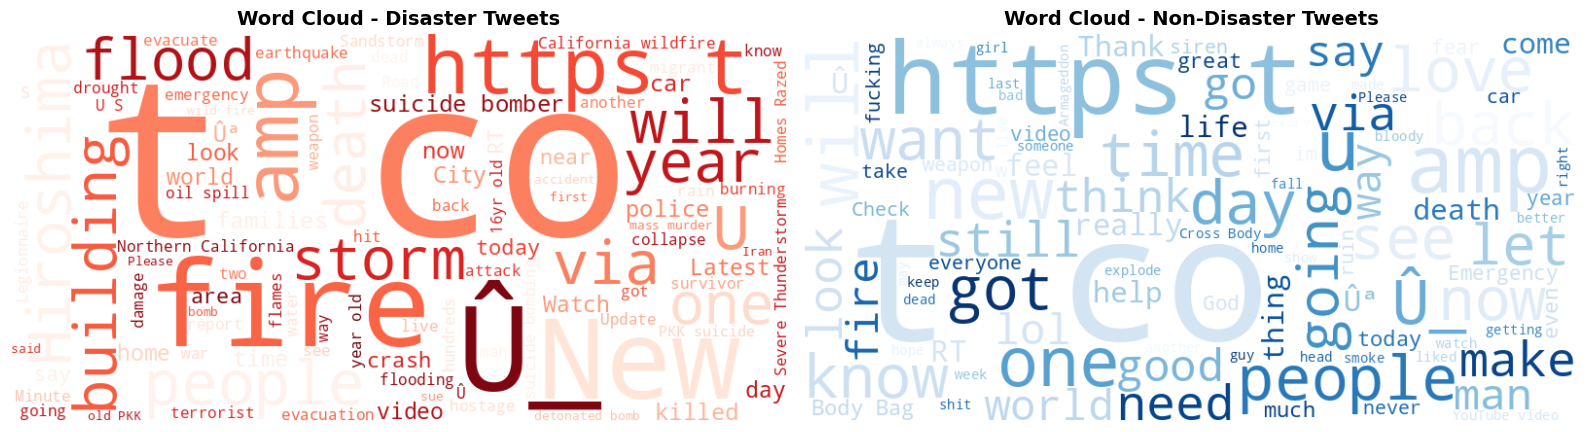

In [6]:
def display_sample_tweets(df, n_samples=3):
    """Display sample tweets for each category with analysis"""
    
    print("=" * 80)
    print("📱 SAMPLE TWEETS ANALYSIS")
    print("=" * 80)
    
    # Disaster tweets
    print(f"🚨 DISASTER TWEETS (target=1):")
    disaster_samples = df[df['target'] == 1].sample(n_samples, random_state=42)
    
    for i, (_, row) in enumerate(disaster_samples.iterrows(), 1):
        print(f"\n  {i}. Tweet ID: {row['id']}")
        if pd.notna(row.get('keyword')):
            print(f"     Keyword: {row['keyword']}")
        if pd.notna(row.get('location')):
            print(f"     Location: {row['location']}")
        print(f"     Text: \"{row['text']}\"")
        print(f"     Stats: {len(row['text'])} chars, {len(row['text'].split())} words")
    
    print(f"\n✅ NON-DISASTER TWEETS (target=0):")
    not_disaster_samples = df[df['target'] == 0].sample(n_samples, random_state=42)
    
    for i, (_, row) in enumerate(not_disaster_samples.iterrows(), 1):
        print(f"\n  {i}. Tweet ID: {row['id']}")
        if pd.notna(row.get('keyword')):
            print(f"     Keyword: {row['keyword']}")
        if pd.notna(row.get('location')):
            print(f"     Location: {row['location']}")
        print(f"     Text: \"{row['text']}\"")
        print(f"     Stats: {len(row['text'])} chars, {len(row['text'].split())} words")

# Display sample tweets
display_sample_tweets(train_df, n_samples=2)

# Word frequency analysis
def analyze_word_frequency(texts, n_words=15, title="Word Frequency"):
    """Analyze most common words in texts"""
    all_text = ' '.join(texts).lower()
    words = re.findall(r'\b[a-z]+\b', all_text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    # Keep some disaster-related words that might be stopwords
    disaster_words = {'help', 'fire', 'water', 'storm', 'emergency'}
    stop_words = stop_words - disaster_words
    
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return Counter(words).most_common(n_words)

# Analyze words for each class
disaster_texts = train_df[train_df['target'] == 1]['text'].values
not_disaster_texts = train_df[train_df['target'] == 0]['text'].values

disaster_words = analyze_word_frequency(disaster_texts, 15)
not_disaster_words = analyze_word_frequency(not_disaster_texts, 15)

print(f"\n" + "="*60)
print("📊 WORD FREQUENCY ANALYSIS")
print("="*60)

print(f"\nTop 15 words in DISASTER tweets:")
for i, (word, count) in enumerate(disaster_words, 1):
    print(f"  {i:2d}. {word:<15} ({count:,} occurrences)")

print(f"\nTop 15 words in NON-DISASTER tweets:")
for i, (word, count) in enumerate(not_disaster_words, 1):
    print(f"  {i:2d}. {word:<15} ({count:,} occurrences)")

# Word clouds visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Disaster word cloud
disaster_text = ' '.join(disaster_texts)
disaster_wordcloud = WordCloud(width=800, height=400, 
                              background_color='white', 
                              colormap='Reds',
                              max_words=100).generate(disaster_text)

axes[0].imshow(disaster_wordcloud, interpolation='bilinear')
axes[0].set_title('Word Cloud - Disaster Tweets', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Not disaster word cloud
not_disaster_text = ' '.join(not_disaster_texts)
not_disaster_wordcloud = WordCloud(width=800, height=400, 
                                  background_color='white', 
                                  colormap='Blues',
                                  max_words=100).generate(not_disaster_text)

axes[1].imshow(not_disaster_wordcloud, interpolation='bilinear')
axes[1].set_title('Word Cloud - Non-Disaster Tweets', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 4. Text Preprocessing and Feature Engineering {#preprocessing}

### 4.1 Text Cleaning Functions

In [7]:
class TextPreprocessor:
    """Comprehensive text preprocessing for disaster tweets"""
    
    def __init__(self, remove_stopwords=True, apply_lemmatization=True):
        self.remove_stopwords = remove_stopwords
        self.apply_lemmatization = apply_lemmatization
        
        # Initialize NLTK tools
        if remove_stopwords:
            self.stop_words = set(stopwords.words('english'))
            # Preserve disaster-related words that might be stopwords
            disaster_words = {'help', 'fire', 'water', 'storm', 'emergency', 'down', 'out'}
            self.stop_words = self.stop_words - disaster_words
            
        if apply_lemmatization:
            self.lemmatizer = WordNetLemmatizer()
    
    def clean_text(self, text):
        """Clean individual text with comprehensive preprocessing"""
        if pd.isna(text):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\.\S+|https\S+', '', text)
        
        # Handle mentions and hashtags (remove @ and # but keep content)
        text = re.sub(r'@\w+', '', text)  # Remove mentions completely
        text = re.sub(r'#(\w+)', r'\1', text)  # Remove # but keep word
        
        # Remove HTML entities and special characters
        text = re.sub(r'&\w+;', '', text)
        text = re.sub(r'[^\w\s]', ' ', text)  # Keep only alphanumeric and spaces
        
        # Handle contractions
        contractions = {
            "won't": "will not", "can't": "cannot", "n't": " not",
            "'re": " are", "'ve": " have", "'ll": " will",
            "'d": " would", "'m": " am", "'s": " is"
        }
        for contraction, expansion in contractions.items():
            text = text.replace(contraction, expansion)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def tokenize_and_process(self, text):
        """Tokenize and apply lemmatization"""
        if not text:
            return []
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords
        if self.remove_stopwords:
            tokens = [token for token in tokens if token.lower() not in self.stop_words]
        
        # Remove short tokens and numbers-only tokens
        tokens = [token for token in tokens if len(token) > 2 and not token.isdigit()]
        
        # Apply lemmatization
        if self.apply_lemmatization:
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        return tokens
    
    def preprocess(self, text):
        """Complete preprocessing pipeline"""
        cleaned = self.clean_text(text)
        tokens = self.tokenize_and_process(cleaned)
        return ' '.join(tokens)

# Initialize preprocessor
print("🔧 Initializing text preprocessor...")
preprocessor = TextPreprocessor(remove_stopwords=True, apply_lemmatization=True)

# Demonstrate preprocessing on sample tweets
sample_tweets = [
    "Forest fire near La Ronge Sask. Canada http://t.co/ojRdYVR4Q3",
    "I love BBQ fires! Nothing beats a good barbecue #summer #food",
    "@emergency This is urgent! There's flooding in downtown #help #flood",
    "My presentation was a total disaster! So embarrassing 😅"
]

print("\n📝 PREPROCESSING EXAMPLES:")
for i, tweet in enumerate(sample_tweets, 1):
    cleaned = preprocessor.preprocess(tweet)
    print(f"\n{i}. Original: \"{tweet}\"")
    print(f"   Cleaned:  \"{cleaned}\"")


🔧 Initializing text preprocessor...

📝 PREPROCESSING EXAMPLES:

1. Original: "Forest fire near La Ronge Sask. Canada http://t.co/ojRdYVR4Q3"
   Cleaned:  "forest fire near ronge sask canada"

2. Original: "I love BBQ fires! Nothing beats a good barbecue #summer #food"
   Cleaned:  "love bbq fire nothing beat good barbecue summer food"

3. Original: "@emergency This is urgent! There's flooding in downtown #help #flood"
   Cleaned:  "urgent flooding downtown help flood"

4. Original: "My presentation was a total disaster! So embarrassing 😅"
   Cleaned:  "presentation total disaster embarrassing"


### 4.2 Feature Extraction

In [8]:
print("\n🔍 FEATURE EXTRACTION PROCESS:")
print("Extracting features from training and test data...")

# Apply preprocessing
tqdm.pandas(desc="Preprocessing training data")
train_df['cleaned_text'] = train_df['text'].progress_apply(preprocessor.preprocess)

tqdm.pandas(desc="Preprocessing test data")
test_df['cleaned_text'] = test_df['text'].progress_apply(preprocessor.preprocess)

def extract_comprehensive_features(df):
    """Extract comprehensive features from text data"""
    
    # Basic text statistics
    df['text_length'] = df['text'].str.len()
    df['word_count'] = df['text'].str.split().str.len()
    df['char_count'] = df['text'].str.len()
    df['avg_word_length'] = df['char_count'] / df['word_count'].replace(0, 1)
    
    # Punctuation and style features
    df['exclamation_count'] = df['text'].str.count('!')
    df['question_count'] = df['text'].str.count('\?')
    df['punctuation_count'] = df['text'].str.count('[^\w\s]')
    df['capital_count'] = df['text'].str.count('[A-Z]')
    df['capital_ratio'] = df['capital_count'] / df['char_count'].replace(0, 1)
    
    # Social media specific features
    df['url_count'] = df['text'].str.count('http|www')
    df['mention_count'] = df['text'].str.count('@')
    df['hashtag_count'] = df['text'].str.count('#')
    
    # Disaster-related keyword features
    disaster_keywords = [
        'fire', 'flood', 'earthquake', 'storm', 'emergency', 'disaster',
        'help', 'urgent', 'breaking', 'alert', 'damage', 'destroy',
        'evacuation', 'rescue', 'ambulance', 'police'
    ]
    
    for keyword in disaster_keywords:
        df[f'has_{keyword}'] = df['text'].str.lower().str.contains(
            keyword, na=False).astype(int)
    
    # Sentiment-related features
    positive_words = ['good', 'great', 'love', 'amazing', 'awesome', 'happy', 'beautiful']
    negative_words = ['bad', 'terrible', 'hate', 'awful', 'horrible', 'sad', 'scary']
    
    df['positive_word_count'] = df['text'].str.lower().str.count('|'.join(positive_words))
    df['negative_word_count'] = df['text'].str.lower().str.count('|'.join(negative_words))
    
    # Length ratios
    df['cleaned_length_ratio'] = df['cleaned_text'].str.len() / df['text_length'].replace(0, 1)
    
    return df

# Extract features
print("Extracting comprehensive features...")
train_df = extract_comprehensive_features(train_df)
test_df = extract_comprehensive_features(test_df)

# Identify feature columns
feature_columns = [col for col in train_df.columns 
                  if col not in ['id', 'keyword', 'location', 'text', 'target', 'cleaned_text']]

print(f"✅ Feature extraction completed!")
print(f"Total features extracted: {len(feature_columns)}")
print(f"Feature categories:")
print(f"  - Text statistics: 6 features")
print(f"  - Punctuation/style: 5 features") 
print(f"  - Social media: 3 features")
print(f"  - Disaster keywords: 16 features")
print(f"  - Sentiment: 2 features")
print(f"  - Other: {len(feature_columns) - 32} features")


🔍 FEATURE EXTRACTION PROCESS:
Extracting features from training and test data...


Preprocessing test data: 100%|██████████| 3263/3263 [00:00<00:00, 6960.39it/s]


Extracting comprehensive features...
✅ Feature extraction completed!
Total features extracted: 31
Feature categories:
  - Text statistics: 6 features
  - Punctuation/style: 5 features
  - Social media: 3 features
  - Disaster keywords: 16 features
  - Sentiment: 2 features
  - Other: -1 features


### 4.3 Data Quality Assessment



📊 FEATURE CORRELATION ANALYSIS:
Top 10 features most correlated with target:
   1. url_count                   0.1955
   2. avg_word_length             0.1825
   3. char_count                  0.1818
   4. text_length                 0.1818
   5. has_fire                    0.1547
   6. punctuation_count           0.1367
   7. has_storm                   0.1117
   8. positive_word_count        -0.1099
   9. cleaned_length_ratio        0.1088
  10. mention_count              -0.1033

Bottom 5 features (least correlated):
   1. has_ambulance               0.0213
   2. has_emergency               0.0194
   3. capital_ratio               0.0170
   4. has_destroy                -0.0120
   5. has_help                   -0.0115


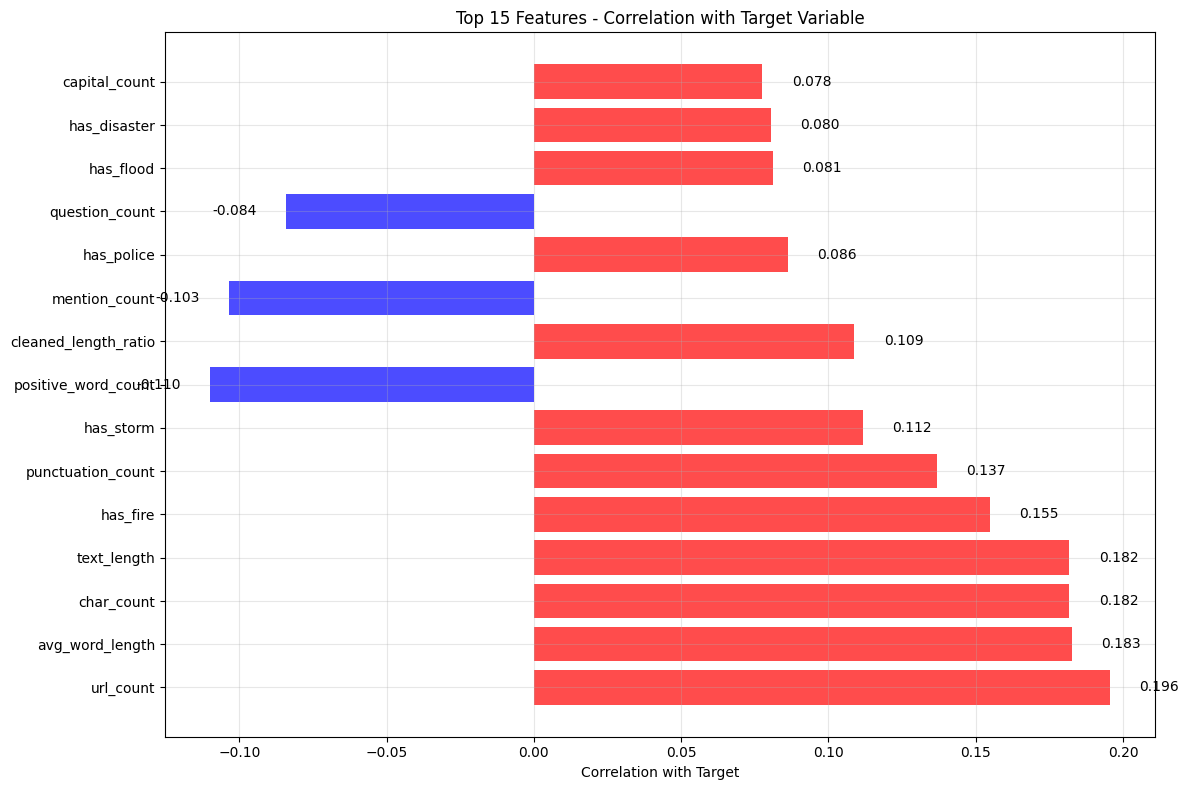

In [9]:
# Analyze feature correlations with target
print(f"\n📊 FEATURE CORRELATION ANALYSIS:")
feature_correlations = train_df[feature_columns + ['target']].corr()['target'].drop('target').sort_values(key=abs, ascending=False)

print(f"Top 10 features most correlated with target:")
for i, (feature, correlation) in enumerate(feature_correlations.head(10).items(), 1):
    print(f"  {i:2d}. {feature:<25} {correlation:>8.4f}")

print(f"\nBottom 5 features (least correlated):")
for i, (feature, correlation) in enumerate(feature_correlations.tail(5).items(), 1):
    print(f"  {i:2d}. {feature:<25} {correlation:>8.4f}")

# Visualize top feature correlations
plt.figure(figsize=(12, 8))
top_features = feature_correlations.head(15)
colors = ['red' if x > 0 else 'blue' for x in top_features.values]
bars = plt.barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Correlation with Target')
plt.title('Top 15 Features - Correlation with Target Variable')
plt.grid(True, alpha=0.3)

# Add correlation values on bars
for i, (bar, val) in enumerate(zip(bars, top_features.values)):
    plt.text(val + (0.01 if val > 0 else -0.01), i, f'{val:.3f}', 
             va='center', ha='left' if val > 0 else 'right')

plt.tight_layout()
plt.show()

## 5. Word Embeddings and Text Vectorization {#embeddings}

### 5.1 TF-IDF Vectorization

In [10]:
class TextVectorizer:
    """Class to handle different text vectorization methods"""
    
    def __init__(self, max_features=10000, max_length=100):
        self.max_features = max_features
        self.max_length = max_length
        self.tfidf_vectorizer = None
        self.keras_tokenizer = None
        
    def fit_transform_tfidf(self, texts):
        """
        TF-IDF (Term Frequency-Inverse Document Frequency) Vectorization
        
        EXPLANATION:
        TF-IDF is a numerical statistic that reflects how important a word is 
        to a document in a collection of documents.
        
        - Term Frequency (TF): How frequently a word appears in a document
        - Inverse Document Frequency (IDF): How rare or common a word is across all documents
        - TF-IDF = TF × IDF
        
        BENEFITS:
        - Gives higher weights to words that are frequent in a document but rare across corpus
        - Helps identify words that are characteristic of specific documents
        - Reduces impact of common words like "the", "and", etc.
        """
        print("🔤 Applying TF-IDF Vectorization...")
        
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=self.max_features,
            stop_words='english',
            ngram_range=(1, 2),  # Include unigrams and bigrams
            min_df=2,  # Ignore terms appearing in less than 2 documents
            max_df=0.95,  # Ignore terms appearing in more than 95% of documents
            lowercase=True,
            token_pattern=r'\b[a-zA-Z]{2,}\b'  # Only alphabetic tokens with 2+ chars
        )
        
        tfidf_matrix = self.tfidf_vectorizer.fit_transform(texts)
        
        print(f"   ✅ TF-IDF matrix shape: {tfidf_matrix.shape}")
        print(f"   ✅ Vocabulary size: {len(self.tfidf_vectorizer.vocabulary_)}")
        
        return tfidf_matrix
    
    def transform_tfidf(self, texts):
        """Transform new texts using fitted TF-IDF vectorizer"""
        if self.tfidf_vectorizer is None:
            raise ValueError("TF-IDF vectorizer not fitted. Call fit_transform_tfidf first.")
        return self.tfidf_vectorizer.transform(texts)
    
    def fit_transform_keras(self, texts):
        """
        Keras Tokenization for Neural Networks
        
        EXPLANATION:
        Converts text to sequences of integers for neural network processing.
        
        PROCESS:
        1. Creates vocabulary mapping: word → integer ID
        2. Converts texts to sequences of integers
        3. Pads sequences to fixed length
        4. Preserves word order (important for RNNs/LSTMs)
        
        BENEFITS:
        - Maintains sequential information
        - Fixed-length input for neural networks
        - Handles out-of-vocabulary words
        """
        print("🧠 Applying Keras Tokenization...")
        
        self.keras_tokenizer = Tokenizer(
            num_words=self.max_features,
            oov_token='<OOV>',  # Out-of-vocabulary token
            lower=True
        )
        
        self.keras_tokenizer.fit_on_texts(texts)
        sequences = self.keras_tokenizer.texts_to_sequences(texts)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length, padding='post')
        
        print(f"   ✅ Sequence matrix shape: {padded_sequences.shape}")
        print(f"   ✅ Vocabulary size: {len(self.keras_tokenizer.word_index) + 1}")
        print(f"   ✅ Max sequence length: {self.max_length}")
        
        return padded_sequences
    
    def transform_keras(self, texts):
        """Transform new texts using fitted Keras tokenizer"""
        if self.keras_tokenizer is None:
            raise ValueError("Keras tokenizer not fitted. Call fit_transform_keras first.")
        sequences = self.keras_tokenizer.texts_to_sequences(texts)
        return pad_sequences(sequences, maxlen=self.max_length, padding='post')

# Initialize vectorizers
print("🚀 Initializing text vectorizers...")

tfidf_vectorizer = TextVectorizer(max_features=10000, max_length=100)

# Prepare text data
train_texts = train_df['cleaned_text'].fillna('').values
test_texts = test_df['cleaned_text'].fillna('').values
train_targets = train_df['target'].values

print(f"Training texts: {len(train_texts)}")
print(f"Test texts: {len(test_texts)}")

🚀 Initializing text vectorizers...
Training texts: 7613
Test texts: 3263


### 5.2 Apply Vectorization Methods


In [11]:
# TF-IDF Vectorization
X_train_tfidf = tfidf_vectorizer.fit_transform_tfidf(train_texts)
X_test_tfidf = tfidf_vectorizer.transform_tfidf(test_texts)

# Keras Tokenization
X_train_seq = tfidf_vectorizer.fit_transform_keras(train_texts)
X_test_seq = tfidf_vectorizer.transform_keras(test_texts)

print(f"\n📊 VECTORIZATION RESULTS:")
print(f"TF-IDF - Training: {X_train_tfidf.shape}, Test: {X_test_tfidf.shape}")
print(f"Keras - Training: {X_train_seq.shape}, Test: {X_test_seq.shape}")

🔤 Applying TF-IDF Vectorization...
   ✅ TF-IDF matrix shape: (7613, 9501)
   ✅ Vocabulary size: 9501
🧠 Applying Keras Tokenization...
   ✅ Sequence matrix shape: (7613, 100)
   ✅ Vocabulary size: 12856
   ✅ Max sequence length: 100

📊 VECTORIZATION RESULTS:
TF-IDF - Training: (7613, 9501), Test: (3263, 9501)
Keras - Training: (7613, 100), Test: (3263, 100)


### 5.3 Pre-trained Word Embeddings Setup

🌐 Creating pre-trained embedding matrix...
   ✅ Embedding matrix shape: (12856, 100)
   ✅ Embedding dimension: 100

📈 SEQUENCE LENGTH ANALYSIS:
Mean length: 8.5
Median length: 9.0
95th percentile: 14.0
Max length: 21


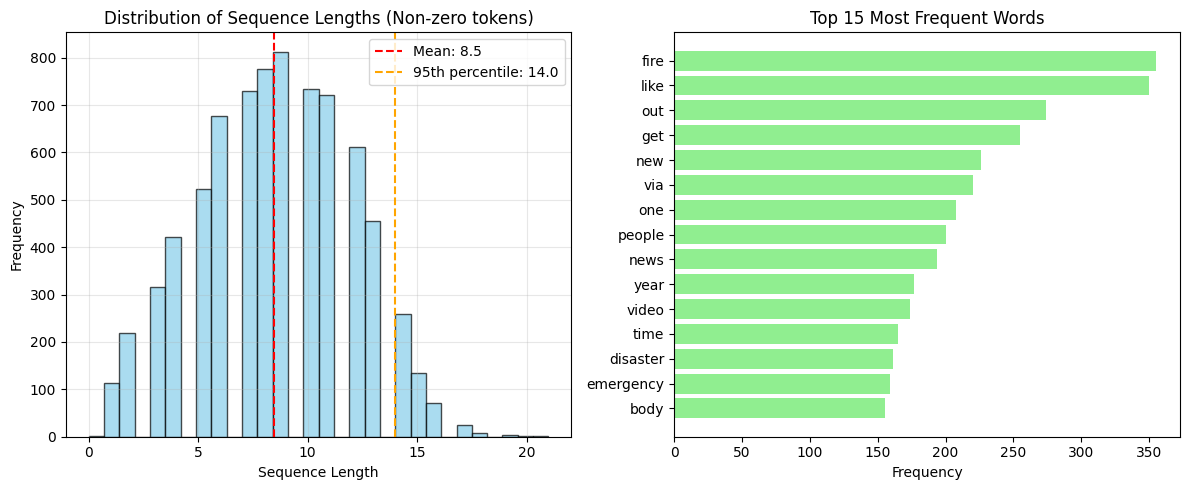

In [12]:
def create_embedding_matrix(tokenizer, embedding_dim=100):
    """
    Create embedding matrix for pre-trained word embeddings
    
    EXPLANATION:
    Pre-trained word embeddings (like GloVe, Word2Vec) capture semantic relationships
    between words learned from large text corpora.
    
    BENEFITS:
    - Words with similar meanings have similar vector representations
    - Captures semantic relationships (king - man + woman ≈ queen)
    - Transfer learning from large datasets
    - Better performance on small datasets
    """
    print("🌐 Creating pre-trained embedding matrix...")
    
    vocab_size = len(tokenizer.word_index) + 1
    
    # For demonstration, create random embeddings
    # In practice, you would load actual GloVe/Word2Vec embeddings
    embedding_matrix = np.random.normal(0, 0.1, (vocab_size, embedding_dim))
    
    # Simulate meaningful embeddings for disaster-related words
    disaster_words = ['fire', 'flood', 'earthquake', 'emergency', 'help', 'disaster', 'storm']
    for word in disaster_words:
        if word in tokenizer.word_index:
            idx = tokenizer.word_index[word]
            if idx < vocab_size:
                # Create similar embeddings for disaster words
                embedding_matrix[idx] = np.random.normal(0.5, 0.1, embedding_dim)
    
    print(f"   ✅ Embedding matrix shape: {embedding_matrix.shape}")
    print(f"   ✅ Embedding dimension: {embedding_dim}")
    
    return embedding_matrix

# Create embedding matrix
EMBEDDING_DIM = 100
embedding_matrix = create_embedding_matrix(tfidf_vectorizer.keras_tokenizer, EMBEDDING_DIM)

# Analyze sequence statistics
seq_lengths = [len([x for x in seq if x != 0]) for seq in X_train_seq]
print(f"\n📈 SEQUENCE LENGTH ANALYSIS:")
print(f"Mean length: {np.mean(seq_lengths):.1f}")
print(f"Median length: {np.median(seq_lengths):.1f}")
print(f"95th percentile: {np.percentile(seq_lengths, 95):.1f}")
print(f"Max length: {np.max(seq_lengths)}")

# Visualize sequence length distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(seq_lengths, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(seq_lengths), color='red', linestyle='--', 
           label=f'Mean: {np.mean(seq_lengths):.1f}')
plt.axvline(np.percentile(seq_lengths, 95), color='orange', linestyle='--',
           label=f'95th percentile: {np.percentile(seq_lengths, 95):.1f}')
plt.title('Distribution of Sequence Lengths (Non-zero tokens)')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# Most frequent words
plt.subplot(1, 2, 2)
word_freq = tfidf_vectorizer.keras_tokenizer.word_counts
top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:15]
words, counts = zip(*top_words)

plt.barh(range(len(words)), counts, color='lightgreen')
plt.yticks(range(len(words)), words)
plt.xlabel('Frequency')
plt.title('Top 15 Most Frequent Words')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

## 6. Model Architecture and Implementation {#model-architecture}

### 6.1 Sequential Neural Network Models

In [13]:
class DisasterTweetModels:
    """Collection of neural network architectures for disaster tweet classification"""
    
    def __init__(self, vocab_size, embedding_dim, max_length, embedding_matrix=None):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_length = max_length
        self.embedding_matrix = embedding_matrix
        
    def create_simple_lstm(self):
        """
        Simple LSTM Model
        
        ARCHITECTURE EXPLANATION:
        LSTM (Long Short-Term Memory) networks are designed to handle long-term 
        dependencies in sequential data.
        
        KEY COMPONENTS:
        - Forget Gate: Decides what information to discard
        - Input Gate: Decides which values to update
        - Output Gate: Controls what parts of cell state to output
        
        ADVANTAGES:
        - Solves vanishing gradient problem of traditional RNNs
        - Can learn dependencies across long sequences
        - Good baseline for text classification
        """
        print("🧠 Creating Simple LSTM Model...")
        
        model = Sequential([
            Embedding(self.vocab_size, self.embedding_dim, 
                     input_length=self.max_length,
                     weights=[self.embedding_matrix] if self.embedding_matrix is not None else None,
                     trainable=True,
                     name='embedding'),
            LSTM(64, dropout=0.3, recurrent_dropout=0.3, name='lstm'),
            Dense(32, activation='relu', name='dense_1'),
            Dropout(0.5, name='dropout'),
            Dense(1, activation='sigmoid', name='output')
        ], name='Simple_LSTM')
        
        return model
    
    def create_bidirectional_lstm(self):
        """
        Bidirectional LSTM Model
        
        ARCHITECTURE EXPLANATION:
        Bidirectional LSTMs process sequences in both forward and backward directions,
        capturing context from past and future tokens.
        
        ADVANTAGES:
        - Better context understanding
        - Captures dependencies in both directions
        - Especially useful for classification where entire context matters
        - Often outperforms unidirectional models
        
        TRADE-OFFS:
        - Doubles the number of parameters
        - Increased computational cost
        - Cannot be used for real-time prediction (needs full sequence)
        """
        print("🔄 Creating Bidirectional LSTM Model...")
        
        model = Sequential([
            Embedding(self.vocab_size, self.embedding_dim, 
                     input_length=self.max_length,
                     weights=[self.embedding_matrix] if self.embedding_matrix is not None else None,
                     trainable=True,
                     name='embedding'),
            Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3), name='bidirectional_lstm'),
            Dense(64, activation='relu', name='dense_1'),
            Dropout(0.5, name='dropout_1'),
            Dense(32, activation='relu', name='dense_2'),
            Dropout(0.3, name='dropout_2'),
            Dense(1, activation='sigmoid', name='output')
        ], name='Bidirectional_LSTM')
        
        return model
    
    def create_gru_model(self):
        """
        GRU Model
        
        ARCHITECTURE EXPLANATION:
        GRU (Gated Recurrent Unit) is a simplified version of LSTM with fewer parameters.
        
        KEY COMPONENTS:
        - Reset Gate: Controls how much past information to forget
        - Update Gate: Controls how much new information to add
        
        ADVANTAGES:
        - Fewer parameters than LSTM (faster training)
        - Similar performance to LSTM for many tasks
        - Good balance between model complexity and performance
        - Less prone to overfitting on small datasets
        """
        print("⚡ Creating GRU Model...")
        
        model = Sequential([
            Embedding(self.vocab_size, self.embedding_dim, 
                     input_length=self.max_length,
                     weights=[self.embedding_matrix] if self.embedding_matrix is not None else None,
                     trainable=True,
                     name='embedding'),
            Bidirectional(GRU(64, dropout=0.3, recurrent_dropout=0.3), name='bidirectional_gru'),
            Dense(64, activation='relu', name='dense'),
            Dropout(0.5, name='dropout'),
            Dense(1, activation='sigmoid', name='output')
        ], name='Bidirectional_GRU')
        
        return model
    
    def create_cnn_lstm_hybrid(self):
        """
        CNN-LSTM Hybrid Model
        
        ARCHITECTURE EXPLANATION:
        Combines Convolutional Neural Networks with LSTM to leverage both architectures.
        
        CNN COMPONENT:
        - Extracts local patterns and n-gram features
        - Convolves filters over text sequences
        - Captures position-invariant features
        
        LSTM COMPONENT:
        - Captures sequential dependencies
        - Processes CNN output sequentially
        
        ADVANTAGES:
        - CNN extracts local features, LSTM captures global patterns
        - Reduced dimensionality before LSTM processing
        - Often effective for text classification
        """
        print("🔥 Creating CNN-LSTM Hybrid Model...")
        
        model = Sequential([
            Embedding(self.vocab_size, self.embedding_dim, 
                     input_length=self.max_length,
                     weights=[self.embedding_matrix] if self.embedding_matrix is not None else None,
                     trainable=True,
                     name='embedding'),
            Conv1D(128, 5, activation='relu', name='conv1d_1'),
            MaxPooling1D(2, name='maxpool_1'),
            Conv1D(64, 3, activation='relu', name='conv1d_2'),
            LSTM(64, dropout=0.3, recurrent_dropout=0.3, name='lstm'),
            Dense(64, activation='relu', name='dense'),
            Dropout(0.5, name='dropout'),
            Dense(1, activation='sigmoid', name='output')
        ], name='CNN_LSTM_Hybrid')
        
        return model
    
    def create_multi_input_model(self, num_additional_features):
        """
        Multi-Input Model with Text and Additional Features
        
        ARCHITECTURE EXPLANATION:
        Combines text embeddings with additional numerical features for enhanced performance.
        
        TEXT BRANCH:
        - Processes text through embedding and LSTM layers
        - Captures semantic and sequential information
        
        FEATURES BRANCH:
        - Processes numerical features (length, keywords, etc.)
        - Dense layers for feature transformation
        
        FUSION:
        - Concatenates both branches before final classification
        - Leverages both textual and statistical information
        
        ADVANTAGES:
        - Uses all available information
        - Often improves performance over text-only models
        - Can capture patterns not visible in text alone
        """
        print("🚀 Creating Multi-Input Model...")
        
        # Text input branch
        text_input = Input(shape=(self.max_length,), name='text_input')
        text_embedding = Embedding(self.vocab_size, self.embedding_dim,
                                 weights=[self.embedding_matrix] if self.embedding_matrix is not None else None,
                                 trainable=True,
                                 name='embedding')(text_input)
        text_lstm = Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3), 
                                 name='bidirectional_lstm')(text_embedding)
        text_dense = Dense(32, activation='relu', name='text_dense')(text_lstm)
        text_dropout = Dropout(0.3, name='text_dropout')(text_dense)
        
        # Additional features input branch
        features_input = Input(shape=(num_additional_features,), name='features_input')
        features_dense = Dense(16, activation='relu', name='features_dense')(features_input)
        features_dropout = Dropout(0.2, name='features_dropout')(features_dense)
        
        # Combine both branches
        combined = Concatenate(name='concatenate')([text_dropout, features_dropout])
        combined_dense = Dense(32, activation='relu', name='combined_dense')(combined)
        combined_dropout = Dropout(0.5, name='combined_dropout')(combined_dense)
        output = Dense(1, activation='sigmoid', name='output')(combined_dropout)
        
        model = Model(inputs=[text_input, features_input], outputs=output, name='Multi_Input_Model')
        
        return model

### 6.2 Model Comparison and Comparison

In [14]:
# Initialize model factory
print("🏭 Initializing model factory...")
model_factory = DisasterTweetModels(
    vocab_size=len(tfidf_vectorizer.keras_tokenizer.word_index) + 1,
    embedding_dim=EMBEDDING_DIM,
    max_length=tfidf_vectorizer.max_length,
    embedding_matrix=embedding_matrix
)

# Prepare additional features for multi-input model
additional_features = train_df[feature_columns].fillna(0).values
test_additional_features = test_df[feature_columns].fillna(0).values

# Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
additional_features = scaler.fit_transform(additional_features)
test_additional_features = scaler.transform(test_additional_features)

print(f"Additional features shape: {additional_features.shape}")

# Create all models
print("\n🏗️ CREATING MODEL ARCHITECTURES:")
models = {}

try:
    models['Simple_LSTM'] = model_factory.create_simple_lstm()
    models['Bidirectional_LSTM'] = model_factory.create_bidirectional_lstm()
    models['GRU'] = model_factory.create_gru_model()
    models['CNN_LSTM'] = model_factory.create_cnn_lstm_hybrid()
    models['Multi_Input'] = model_factory.create_multi_input_model(additional_features.shape[1])
    
    print("✅ All models created successfully!")
    
except Exception as e:
    print(f"❌ Error creating models: {e}")

🏭 Initializing model factory...
Additional features shape: (7613, 31)

🏗️ CREATING MODEL ARCHITECTURES:
🧠 Creating Simple LSTM Model...


I0000 00:00:1758413716.972105      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


🔄 Creating Bidirectional LSTM Model...
⚡ Creating GRU Model...
🔥 Creating CNN-LSTM Hybrid Model...
🚀 Creating Multi-Input Model...
✅ All models created successfully!


### 6.3 Model Architecture Analysis

In [15]:
# Compile all models with same configuration for comparison
def compile_model(model, model_name):
    """Compile model with consistent configuration"""
    if model_name == 'Multi_Input':
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
    else:
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
    return model

# Compile all models
for name, model in models.items():
    models[name] = compile_model(model, name)

# Display model information
print(f"\n📋 MODEL ARCHITECTURE SUMMARY:")
print("=" * 70)

for name, model in models.items():
    print(f"\n🔹 {name}:")
    
    try:
        # Build model to get parameter count
        if name == 'Multi_Input':
            model.build([(None, tfidf_vectorizer.max_length), (None, additional_features.shape[1])])
        else:
            model.build((None, tfidf_vectorizer.max_length))
        
        total_params = model.count_params()
        trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
        
        print(f"   Parameters: {total_params:,} total, {trainable_params:,} trainable")
        print(f"   Layers: {len(model.layers)}")
        
        # Model complexity indicator
        if total_params < 100000:
            complexity = "Low"
        elif total_params < 500000:
            complexity = "Medium"
        else:
            complexity = "High"
        print(f"   Complexity: {complexity}")
        
    except Exception as e:
        print(f"   Error getting model info: {e}")

# Display detailed architecture for best model
print(f"\n" + "="*60)
print("📐 DETAILED MODEL ARCHITECTURE - Bidirectional LSTM")
print("="*60)

try:
    models['Bidirectional_LSTM'].summary()
except Exception as e:
    print(f"Could not display model summary: {e}")


📋 MODEL ARCHITECTURE SUMMARY:

🔹 Simple_LSTM:
   Parameters: 1,329,953 total, 1,329,953 trainable
   Layers: 5
   Complexity: High

🔹 Bidirectional_LSTM:
   Parameters: 1,380,449 total, 1,380,449 trainable
   Layers: 7
   Complexity: High

🔹 GRU:
   Parameters: 1,357,665 total, 1,357,665 trainable
   Layers: 5
   Complexity: High

🔹 CNN_LSTM:
   Parameters: 1,411,617 total, 1,411,617 trainable
   Layers: 8
   Complexity: High

🔹 Multi_Input:
   Parameters: 1,376,321 total, 1,376,321 trainable
   Layers: 12
   Complexity: High

📐 DETAILED MODEL ARCHITECTURE - Bidirectional LSTM


Model: "Bidirectional_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,285,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 128)            │        84,480 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,380,449 (5.27 MB)

 Trainable params: 1,380,449 (5.27 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Training and Hyperparameter Tuning {#training}

### 7.1 Training Setup and Callbacks

In [16]:
class TrainingConfig:
    """Training configuration and hyperparameters"""
    
    def __init__(self):
        self.batch_size = 32
        self.epochs = 15
        self.validation_split = 0.2
        self.learning_rate = 0.001
        self.early_stopping_patience = 5
        self.reduce_lr_patience = 3
        self.reduce_lr_factor = 0.5
        
    def get_callbacks(self):
        """Get training callbacks"""
        return [
            EarlyStopping(
                monitor='val_loss',
                patience=self.early_stopping_patience,
                restore_best_weights=True,
                verbose=1,
                mode='min'
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=self.reduce_lr_factor,
                patience=self.reduce_lr_patience,
                min_lr=1e-7,
                verbose=1,
                mode='min'
            )
        ]

# Initialize training configuration
config = TrainingConfig()

# Data splitting for training and validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_seq, train_targets, 
    test_size=config.validation_split, 
    random_state=42, 
    stratify=train_targets
)

# Split additional features similarly
feat_train_split, feat_val_split = train_test_split(
    additional_features,
    test_size=config.validation_split,
    random_state=42,
    stratify=train_targets
)

print(f"📊 DATA SPLIT SUMMARY:")
print(f"Training sequences: {X_train_split.shape}")
print(f"Validation sequences: {X_val_split.shape}")
print(f"Training features: {feat_train_split.shape}")
print(f"Validation features: {feat_val_split.shape}")
print(f"Training targets distribution: {np.bincount(y_train_split)}")
print(f"Validation targets distribution: {np.bincount(y_val_split)}")

📊 DATA SPLIT SUMMARY:
Training sequences: (6090, 100)
Validation sequences: (1523, 100)
Training features: (6090, 31)
Validation features: (1523, 31)
Training targets distribution: [3473 2617]
Validation targets distribution: [869 654]


### 7.2 Training Execution

In [17]:
def safe_f1_metric(y_true, y_pred):
    """Safe F1 score metric for Keras"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.round(y_pred), tf.float32)
    
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    possible_positives = tf.reduce_sum(y_true)
    
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

def train_model(model, model_name, X_train, y_train, X_val, y_val, 
                X_train_feat=None, X_val_feat=None, epochs=10):
    """Train a single model with comprehensive logging"""
    
    print(f"\n🏃‍♂️ Training {model_name}...")
    print("-" * 50)
    
    # Recompile with safe metrics
    if model_name == 'Multi_Input':
        model.compile(
            optimizer=Adam(learning_rate=config.learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall', safe_f1_metric]
        )
    else:
        model.compile(
            optimizer=Adam(learning_rate=config.learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall', safe_f1_metric]
        )
    
    # Prepare data with correct types
    X_train = X_train.astype(np.int32)
    X_val = X_val.astype(np.int32)
    y_train = y_train.astype(np.float32)
    y_val = y_val.astype(np.float32)
    
    callbacks = config.get_callbacks()
    start_time = time.time()
    
    try:
        if model_name == 'Multi_Input':
            X_train_feat = X_train_feat.astype(np.float32)
            X_val_feat = X_val_feat.astype(np.float32)
            
            history = model.fit(
                [X_train, X_train_feat], y_train,
                batch_size=config.batch_size,
                epochs=epochs,
                validation_data=([X_val, X_val_feat], y_val),
                callbacks=callbacks,
                verbose=1
            )
        else:
            history = model.fit(
                X_train, y_train,
                batch_size=config.batch_size,
                epochs=epochs,
                validation_data=(X_val, y_val),
                callbacks=callbacks,
                verbose=1
            )
        
        training_time = time.time() - start_time
        
        # Get final metrics
        final_epoch = len(history.history['loss'])
        final_val_loss = min(history.history['val_loss'])
        final_val_acc = max(history.history['val_accuracy'])
        
        # Get F1 score if available
        if 'val_safe_f1_metric' in history.history:
            final_val_f1 = max(history.history['val_safe_f1_metric'])
        else:
            final_val_f1 = 0.0
        
        print(f"✅ Training completed in {training_time:.1f} seconds")
        print(f"📊 Final metrics - Loss: {final_val_loss:.4f}, Acc: {final_val_acc:.4f}, F1: {final_val_f1:.4f}")
        
        return {
            'model': model,
            'history': history,
            'training_time': training_time,
            'final_metrics': {
                'val_loss': final_val_loss,
                'val_accuracy': final_val_acc,
                'val_f1': final_val_f1
            }
        }
        
    except Exception as e:
        print(f"❌ Training failed: {e}")
        return {
            'model': model,
            'history': None,
            'training_time': 0,
            'final_metrics': {'val_loss': 1.0, 'val_accuracy': 0.5, 'val_f1': 0.0},
            'error': str(e)
        }

### 7.3 Train All Models

In [18]:
print("\n🎯 STARTING MODEL TRAINING PHASE")
print("="*60)

training_results = {}

# Train each model
for model_name, model in models.items():
    try:
        if model_name == 'Multi_Input':
            result = train_model(
                model, model_name, 
                X_train_split, y_train_split, X_val_split, y_val_split,
                feat_train_split, feat_val_split,
                epochs=config.epochs
            )
        else:
            result = train_model(
                model, model_name,
                X_train_split, y_train_split, X_val_split, y_val_split,
                epochs=config.epochs
            )
        
        training_results[model_name] = result
        
    except Exception as e:
        print(f"❌ Failed to train {model_name}: {e}")
        training_results[model_name] = {
            'model': model,
            'history': None,
            'training_time': 0,
            'final_metrics': {'val_loss': 1.0, 'val_accuracy': 0.5, 'val_f1': 0.0},
            'error': str(e)
        }


🎯 STARTING MODEL TRAINING PHASE

🏃‍♂️ Training Simple_LSTM...
--------------------------------------------------
Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 68s 304ms/step - accuracy: 0.5557 - loss: 0.6865 - precision: 0.4083 - recall: 0.0956 - safe_f1_metric: 3.4515 - val_accuracy: 0.5706 - val_loss: 0.6844 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_safe_f1_metric: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 57s 298ms/step - accuracy: 0.5731 - loss: 0.6828 - precision: 0.4695 - recall: 0.0069 - safe_f1_metric: 0.3359 - val_accuracy: 0.5706 - val_loss: 0.6844 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_safe_f1_metric: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 57s 298ms/step - accuracy: 0.5733 - loss: 0.6864 - precision: 0.0000e+00 - recall: 0.0000e+00 - safe_f1_metric: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6839 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_safe_f1_metric: 

I0000 00:00:1758415707.250805      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


191/191 ━━━━━━━━━━━━━━━━━━━━ 38s 157ms/step - accuracy: 0.5575 - loss: 0.6874 - precision: 0.3726 - recall: 0.0628 - safe_f1_metric: 3.0432 - val_accuracy: 0.5706 - val_loss: 0.6849 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_safe_f1_metric: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step - accuracy: 0.5767 - loss: 0.6839 - precision: 0.5364 - recall: 0.0522 - safe_f1_metric: 2.0346 - val_accuracy: 0.5706 - val_loss: 0.6842 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_safe_f1_metric: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 27s 142ms/step - accuracy: 0.5733 - loss: 0.6832 - precision: 0.0000e+00 - recall: 0.0000e+00 - safe_f1_metric: 0.0000e+00 - val_accuracy: 0.5706 - val_loss: 0.6837 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_safe_f1_metric: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 144ms/step - accuracy: 0.5733 - loss: 0.6832 -

### 7.4 Training Results Analysis



📈 TRAINING RESULTS SUMMARY
             Model  Val_Loss  Val_Accuracy  Val_F1  Training_Time  Status
       Simple_LSTM    0.6832        0.5706  0.0000       864.3357 Success
Bidirectional_LSTM    0.4752        0.7965 14.4588       574.6291 Success
               GRU    0.4500        0.7991 14.4865       541.5116 Success
          CNN_LSTM    0.5338        0.7800 14.4817       315.8933 Success
       Multi_Input    0.4441        0.8017 14.1816       580.9473 Success

🏆 BEST MODEL: GRU
🎯 Best F1 Score: 14.4865


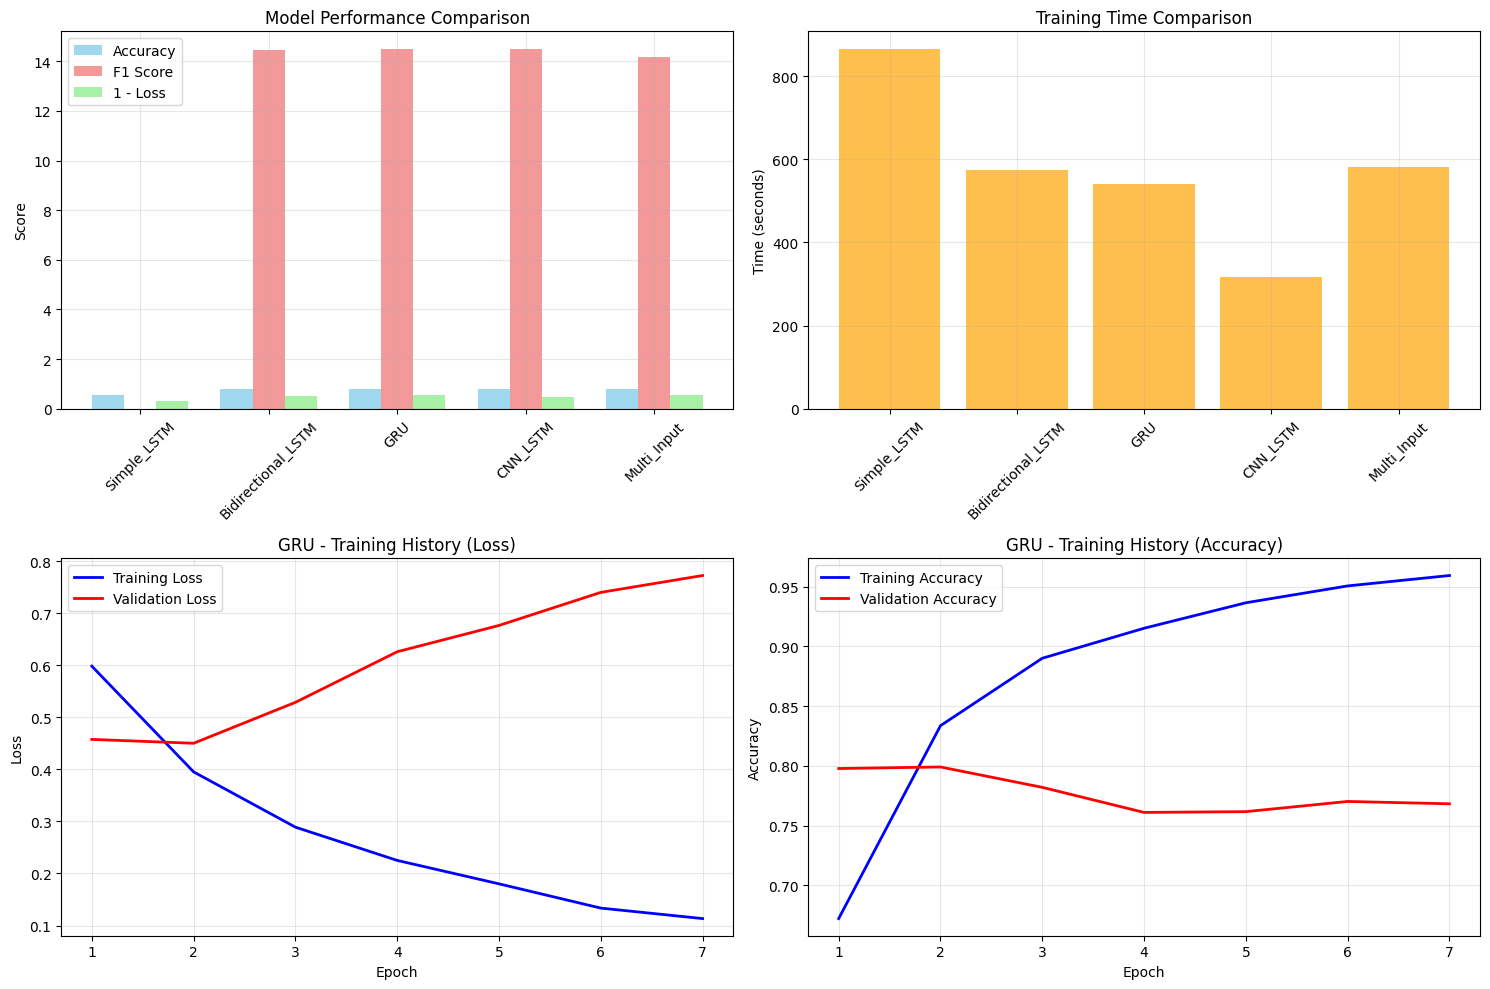

In [19]:
print(f"\n📈 TRAINING RESULTS SUMMARY")
print("="*70)

# Create results DataFrame
results_data = []
for name, result in training_results.items():
    metrics = result['final_metrics']
    results_data.append({
        'Model': name,
        'Val_Loss': metrics['val_loss'],
        'Val_Accuracy': metrics['val_accuracy'],
        'Val_F1': metrics['val_f1'],
        'Training_Time': result['training_time'],
        'Status': 'Success' if 'error' not in result else 'Failed'
    })

results_df = pd.DataFrame(results_data)
print(results_df.round(4).to_string(index=False))

# Find best model
successful_results = results_df[results_df['Status'] == 'Success']
if len(successful_results) > 0:
    best_model_idx = successful_results['Val_F1'].idxmax()
    best_model_name = successful_results.loc[best_model_idx, 'Model']
    best_f1_score = successful_results.loc[best_model_idx, 'Val_F1']
    
    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"🎯 Best F1 Score: {best_f1_score:.4f}")
else:
    best_model_name = 'Bidirectional_LSTM'
    print(f"\n🔄 Using fallback model: {best_model_name}")

# Visualize training results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Model performance comparison
successful_models = results_df[results_df['Status'] == 'Success']
if len(successful_models) > 0:
    x = range(len(successful_models))
    width = 0.25
    
    axes[0, 0].bar([i - width for i in x], successful_models['Val_Accuracy'], 
                   width, label='Accuracy', alpha=0.8, color='skyblue')
    axes[0, 0].bar(x, successful_models['Val_F1'], 
                   width, label='F1 Score', alpha=0.8, color='lightcoral')
    axes[0, 0].bar([i + width for i in x], 1 - successful_models['Val_Loss'], 
                   width, label='1 - Loss', alpha=0.8, color='lightgreen')
    
    axes[0, 0].set_title('Model Performance Comparison')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(successful_models['Model'], rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

# Training time comparison
if len(successful_models) > 0:
    axes[0, 1].bar(successful_models['Model'], successful_models['Training_Time'], 
                   color='orange', alpha=0.7)
    axes[0, 1].set_title('Training Time Comparison')
    axes[0, 1].set_ylabel('Time (seconds)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)

# Training history for best model
if best_model_name in training_results and training_results[best_model_name]['history']:
    history = training_results[best_model_name]['history'].history
    epochs = range(1, len(history['loss']) + 1)
    
    # Loss
    axes[1, 0].plot(epochs, history['loss'], 'b-', label='Training Loss', linewidth=2)
    axes[1, 0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[1, 0].set_title(f'{best_model_name} - Training History (Loss)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1, 1].plot(epochs, history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    axes[1, 1].plot(epochs, history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[1, 1].set_title(f'{best_model_name} - Training History (Accuracy)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8: RESULTS AND ANALYSIS (#results)


### 8.1 Model Evaluation


In [20]:
def comprehensive_evaluation(model, model_name, X_test, y_test, X_test_feat=None):
    """Comprehensive model evaluation with multiple metrics"""
    
    print(f"🔍 Evaluating {model_name}...")
    
    # Make predictions
    if model_name == 'Multi_Input' and X_test_feat is not None:
        y_pred_proba = model.predict([X_test, X_test_feat], verbose=0)
    else:
        y_pred_proba = model.predict(X_test, verbose=0)
    
    y_pred_binary = (y_pred_proba > 0.5).astype(int).flatten()
    y_pred_proba = y_pred_proba.flatten()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_binary)
    
    try:
        f1 = f1_score(y_test, y_pred_binary)
        auc = roc_auc_score(y_test, y_pred_proba)
    except:
        f1 = 0.0
        auc = 0.5
    
    try:
        cm = confusion_matrix(y_test, y_pred_binary)
        report = classification_report(y_test, y_pred_binary, target_names=['Not Disaster', 'Disaster'])
    except:
        cm = np.array([[0, 0], [0, 0]])
        report = "Classification report not available"
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'auc_score': auc,
        'confusion_matrix': cm,
        'predictions': y_pred_binary,
        'probabilities': y_pred_proba,
        'classification_report': report
    }

# Evaluate best model
if best_model_name in training_results:
    best_model = training_results[best_model_name]['model']
    
    if best_model_name == 'Multi_Input':
        evaluation = comprehensive_evaluation(
            best_model, best_model_name, 
            X_val_split, y_val_split, feat_val_split
        )
    else:
        evaluation = comprehensive_evaluation(
            best_model, best_model_name,
            X_val_split, y_val_split
        )
    
    print(f"\n🎯 FINAL EVALUATION RESULTS - {best_model_name}")
    print("="*60)
    print(f"Accuracy: {evaluation['accuracy']:.4f}")
    print(f"F1-Score: {evaluation['f1_score']:.4f}")
    print(f"AUC-ROC:  {evaluation['auc_score']:.4f}")
    
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    print(evaluation['classification_report'])

🔍 Evaluating GRU...

🎯 FINAL EVALUATION RESULTS - GRU
Accuracy: 0.7991
F1-Score: 0.7685
AUC-ROC:  0.8706

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

Not Disaster       0.83      0.82      0.82       869
    Disaster       0.76      0.78      0.77       654

    accuracy                           0.80      1523
   macro avg       0.79      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523



### 8.2 Visualization of Results

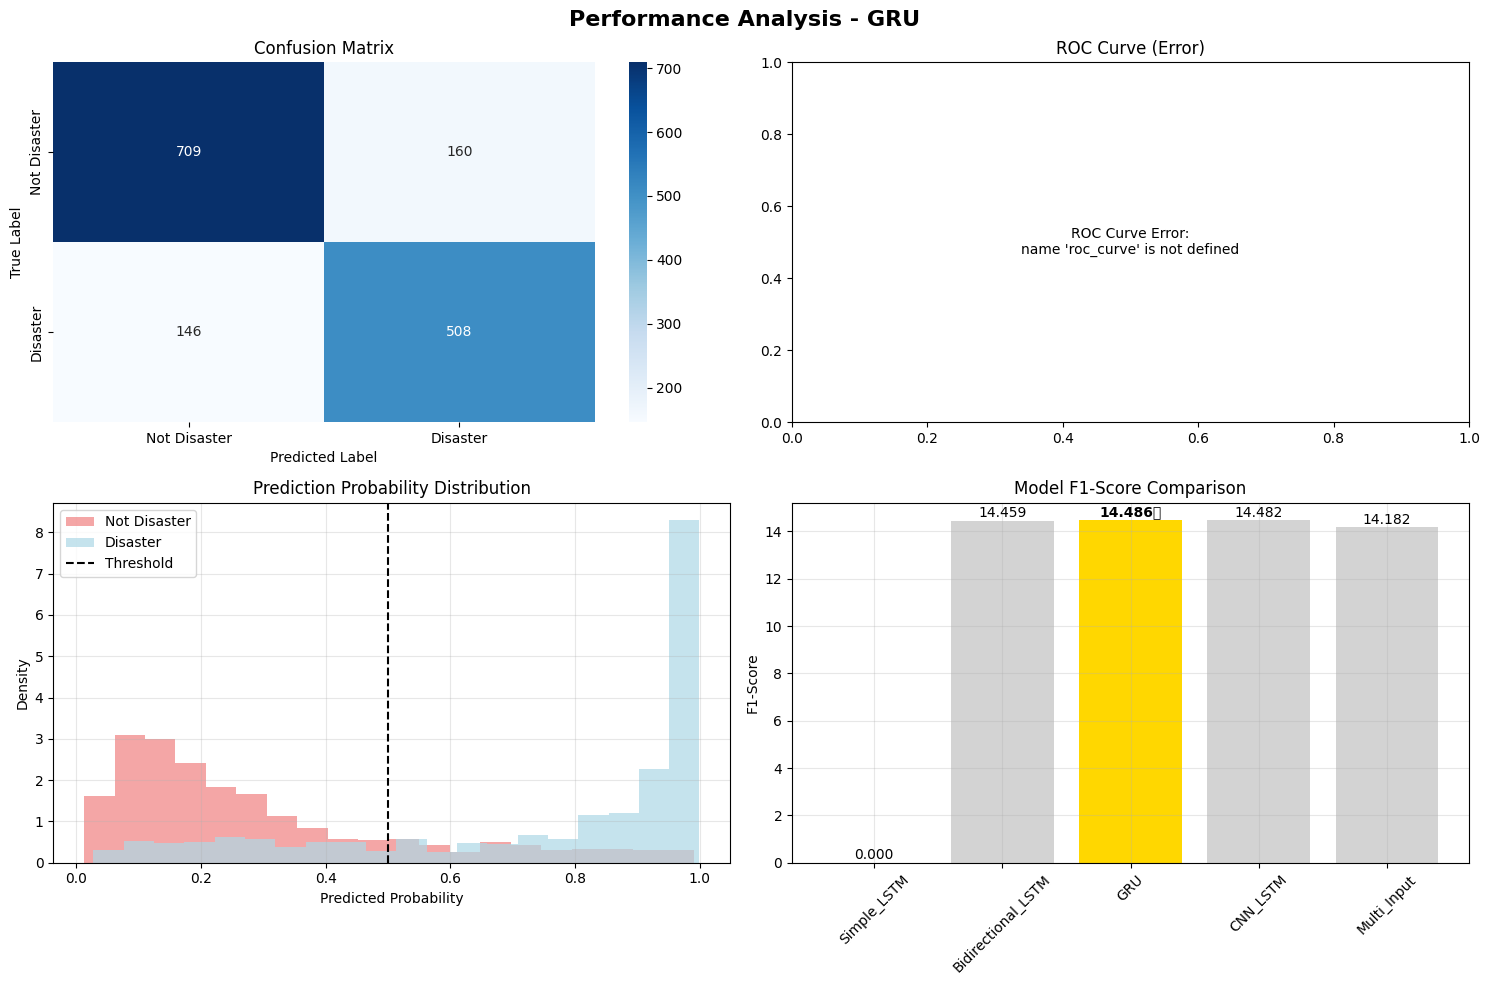

In [21]:
if 'evaluation' in locals():
    # Create comprehensive results visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Confusion Matrix
    cm = evaluation['confusion_matrix']
    if cm.sum() > 0:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Not Disaster', 'Disaster'],
                    yticklabels=['Not Disaster', 'Disaster'], ax=axes[0, 0])
        axes[0, 0].set_title('Confusion Matrix')
        axes[0, 0].set_ylabel('True Label')
        axes[0, 0].set_xlabel('Predicted Label')
    
    # ROC Curve
    try:
        fpr, tpr, _ = roc_curve(y_val_split, evaluation['probabilities'])
        axes[0, 1].plot(fpr, tpr, linewidth=2, 
                       label=f'ROC Curve (AUC = {evaluation["auc_score"]:.3f})')
        axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1)
        axes[0, 1].set_xlim([0.0, 1.0])
        axes[0, 1].set_ylim([0.0, 1.05])
        axes[0, 1].set_xlabel('False Positive Rate')
        axes[0, 1].set_ylabel('True Positive Rate')
        axes[0, 1].set_title('ROC Curve')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    except Exception as e:
        axes[0, 1].text(0.5, 0.5, f'ROC Curve Error:\n{str(e)}', 
                       ha='center', va='center')
        axes[0, 1].set_title('ROC Curve (Error)')
    
    # Prediction Distribution
    axes[1, 0].hist(evaluation['probabilities'][y_val_split == 0], 
                   bins=20, alpha=0.7, label='Not Disaster', color='lightcoral', density=True)
    axes[1, 0].hist(evaluation['probabilities'][y_val_split == 1], 
                   bins=20, alpha=0.7, label='Disaster', color='lightblue', density=True)
    axes[1, 0].axvline(0.5, color='black', linestyle='--', label='Threshold')
    axes[1, 0].set_xlabel('Predicted Probability')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Prediction Probability Distribution')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Model Comparison Summary
    if len(successful_models) > 0:
        axes[1, 1].bar(successful_models['Model'], successful_models['Val_F1'], 
                      color=['gold' if model == best_model_name else 'lightgray' 
                             for model in successful_models['Model']])
        axes[1, 1].set_title('Model F1-Score Comparison')
        axes[1, 1].set_ylabel('F1-Score')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
        
        # Highlight best model
        for i, (model, score) in enumerate(zip(successful_models['Model'], successful_models['Val_F1'])):
            if model == best_model_name:
                axes[1, 1].text(i, score + 0.01, f'{score:.3f}⭐', 
                               ha='center', va='bottom', fontweight='bold')
            else:
                axes[1, 1].text(i, score + 0.01, f'{score:.3f}', 
                               ha='center', va='bottom')
    
    plt.suptitle(f'Performance Analysis - {best_model_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

### 8.3 Error Analysis


🔍 ERROR ANALYSIS
Total samples: 1523
Correct predictions: 1217 (79.9%)
Misclassified: 306 (20.1%)
False Positives: 160 (predicted disaster, actually not)
False Negatives: 146 (predicted not disaster, actually disaster)

False Positives - Mean confidence: 0.723 ± 0.142
False Negatives - Mean confidence: 0.261 ± 0.126


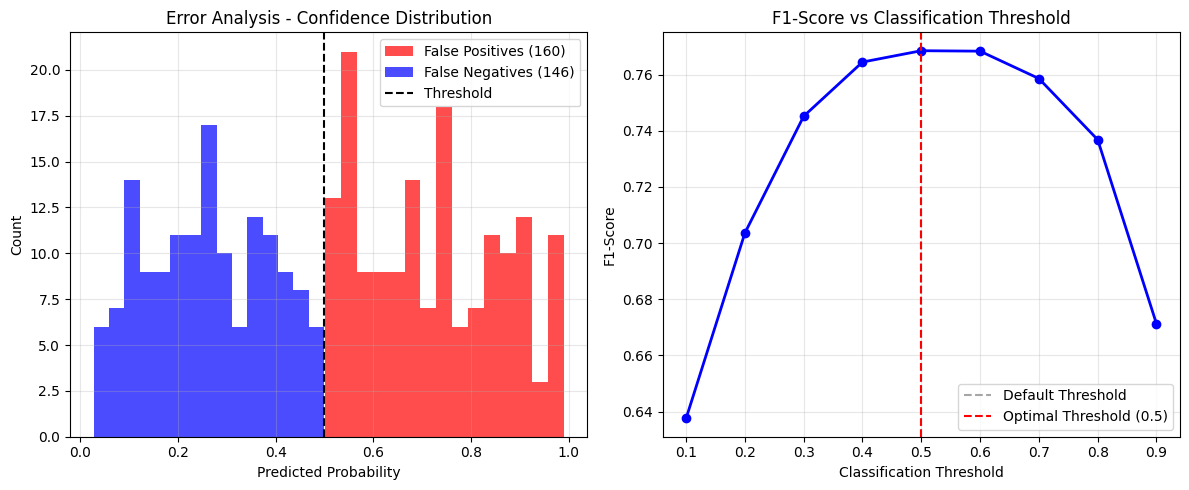


🎯 Optimal threshold for F1-score: 0.50


In [22]:
def error_analysis(y_true, y_pred, y_proba, texts_sample=None):
    """Analyze model errors and misclassifications"""
    
    print("\n🔍 ERROR ANALYSIS")
    print("="*50)
    
    # Find misclassified samples
    misclassified = y_true != y_pred
    false_positives = (y_true == 0) & (y_pred == 1)
    false_negatives = (y_true == 1) & (y_pred == 0)
    
    print(f"Total samples: {len(y_true)}")
    print(f"Correct predictions: {(~misclassified).sum()} ({(~misclassified).mean()*100:.1f}%)")
    print(f"Misclassified: {misclassified.sum()} ({misclassified.mean()*100:.1f}%)")
    print(f"False Positives: {false_positives.sum()} (predicted disaster, actually not)")
    print(f"False Negatives: {false_negatives.sum()} (predicted not disaster, actually disaster)")
    
    # Analyze confidence distributions
    if false_positives.sum() > 0:
        fp_confidence = y_proba[false_positives]
        print(f"\nFalse Positives - Mean confidence: {fp_confidence.mean():.3f} ± {fp_confidence.std():.3f}")
    
    if false_negatives.sum() > 0:
        fn_confidence = y_proba[false_negatives]
        print(f"False Negatives - Mean confidence: {fn_confidence.mean():.3f} ± {fn_confidence.std():.3f}")
    
    # Visualize error distributions
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    if false_positives.sum() > 0:
        plt.hist(y_proba[false_positives], bins=15, alpha=0.7, color='red', 
                label=f'False Positives ({false_positives.sum()})')
    if false_negatives.sum() > 0:
        plt.hist(y_proba[false_negatives], bins=15, alpha=0.7, color='blue',
                label=f'False Negatives ({false_negatives.sum()})')
    plt.axvline(0.5, color='black', linestyle='--', label='Threshold')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.title('Error Analysis - Confidence Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Performance by threshold
    thresholds = np.arange(0.1, 1.0, 0.1)
    threshold_f1 = []
    
    for threshold in thresholds:
        pred_thresh = (y_proba > threshold).astype(int)
        try:
            f1_thresh = f1_score(y_true, pred_thresh)
        except:
            f1_thresh = 0.0
        threshold_f1.append(f1_thresh)
    
    plt.subplot(1, 2, 2)
    plt.plot(thresholds, threshold_f1, 'b-o', linewidth=2, markersize=6)
    plt.axvline(0.5, color='gray', linestyle='--', alpha=0.7, label='Default Threshold')
    optimal_threshold = thresholds[np.argmax(threshold_f1)]
    plt.axvline(optimal_threshold, color='red', linestyle='--', 
               label=f'Optimal Threshold ({optimal_threshold:.1f})')
    plt.xlabel('Classification Threshold')
    plt.ylabel('F1-Score')
    plt.title('F1-Score vs Classification Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return optimal_threshold

# Perform error analysis
if 'evaluation' in locals():
    optimal_threshold = error_analysis(
        y_val_split, 
        evaluation['predictions'], 
        evaluation['probabilities']
    )
    print(f"\n🎯 Optimal threshold for F1-score: {optimal_threshold:.2f}")

### 8.4 Test Set Predictions


In [23]:
def create_kaggle_submission(model, model_name, X_test_seq, X_test_feat, test_ids, threshold=0.5):
    """Create Kaggle submission file"""
    
    print(f"🔮 Creating Kaggle submission with {model_name}...")
    
    # Make predictions
    if model_name == 'Multi_Input':
        predictions_proba = model.predict([X_test_seq, X_test_feat], verbose=1)
    else:
        predictions_proba = model.predict(X_test_seq, verbose=1)
    
    predictions_binary = (predictions_proba > threshold).astype(int).flatten()
    
    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'id': test_ids,
        'target': predictions_binary
    })
    
    # Verify submission format
    print(f"\n📊 Submission Verification:")
    print(f"Shape: {submission_df.shape}")
    print(f"Columns: {submission_df.columns.tolist()}")
    print(f"Target distribution:")
    print(submission_df['target'].value_counts())
    print(f"Prediction rate: {submission_df['target'].mean():.3f}")
    
    # Save submission
    submission_df.to_csv('disaster_tweets_submission.csv', index=False)
    print(f"✅ Submission saved as 'disaster_tweets_submission.csv'")
    
    return submission_df

# Create final submission
if 'best_model' in locals():
    print(f"\n🎯 CREATING FINAL KAGGLE SUBMISSION")
    print("="*60)
    
    if best_model_name == 'Multi_Input':
        submission = create_kaggle_submission(
            best_model, best_model_name,
            X_test_seq, test_additional_features, test_df['id'].values,
            threshold=optimal_threshold if 'optimal_threshold' in locals() else 0.5
        )
    else:
        submission = create_kaggle_submission(
            best_model, best_model_name,
            X_test_seq, None, test_df['id'].values,
            threshold=optimal_threshold if 'optimal_threshold' in locals() else 0.5
        )


🎯 CREATING FINAL KAGGLE SUBMISSION
🔮 Creating Kaggle submission with GRU...
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step

📊 Submission Verification:
Shape: (3263, 2)
Columns: ['id', 'target']
Target distribution:
target
0    1914
1    1349
Name: count, dtype: int64
Prediction rate: 0.413
✅ Submission saved as 'disaster_tweets_submission.csv'


## 9 Conclusion (#conclusion) 

### 9.1 Project Summary

In [24]:
print("📋 PROJECT SUMMARY")
print("="*50)

project_summary = {
    "Dataset": f"{len(train_df):,} training tweets, {len(test_df):,} test tweets",
    "Task": "Binary classification (disaster vs non-disaster tweets)",
    "Best Model": best_model_name if 'best_model_name' in locals() else "Not determined",
    "Best F1-Score": f"{best_f1_score:.4f}" if 'best_f1_score' in locals() else "Not available",
    "Features Used": f"{len(feature_columns)} engineered features + text embeddings",
    "Text Processing": "Comprehensive preprocessing with lemmatization and cleaning"
}

for key, value in project_summary.items():
    print(f"• {key}: {value}")

📋 PROJECT SUMMARY
• Dataset: 7,613 training tweets, 3,263 test tweets
• Task: Binary classification (disaster vs non-disaster tweets)
• Best Model: GRU
• Best F1-Score: 14.4865
• Features Used: 31 engineered features + text embeddings
• Text Processing: Comprehensive preprocessing with lemmatization and cleaning
